Install prerequisites and import appropriate functions

In [138]:
%pip install pandas matplotlib scikit-learn seaborn ipympl scipy
import pandas as pd
%matplotlib widget
#%matplotlib widget
#%matplotlib
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
import seaborn as sns
from itertools import combinations
from scipy.signal import savgol_filter
from scipy.sparse import diags
from scipy.linalg import solve



[notice] A new release of pip available: 22.3 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Read input CSV from the folder and print it to confirm successful read

In [139]:
df_pm = pd.read_csv('30-3-2023  -  11-25.csv',delimiter=',',header='infer')
df_pm

DateTime  Fidas 200 PM2.5  SPS30 PM2.5  SEN55 PM2.5  \
0       2023-3-30 11:26:3            20.49        15.90         17.0   
1       2023-3-30 11:26:9            20.49        16.26         17.3   
2      2023-3-30 11:26:15            20.49        16.99         17.5   
3      2023-3-30 11:26:20            20.49        17.14         17.7   
4      2023-3-30 11:26:26            20.50        17.52         17.8   
...                   ...              ...          ...          ...   
76002    2023-4-4 9:40:36             0.33         0.29          0.4   
76003    2023-4-4 9:40:42             0.33         0.35          0.4   
76004    2023-4-4 9:40:47             0.33         0.40          0.3   
76005    2023-4-4 9:40:53             0.34         0.44          0.3   
76006    2023-4-4 9:40:59             0.34         0.45          0.3   

       HPMA115 PM2.5  NextPM PM2.5  SDS011 PM2.5  
0                 36           0.0          10.2  
1                 36           0.0          10.1  
2                 17           0.0          10.2  
3                 16           0.0           9.9  
4                 16           0.0          10.1  
...              ...           ...           ...  
76002              0           0.2           0.5  
76003              0           0.3           0.5  
76004              0           1.8           0.5  
76005              0           1.7           0.5  
76006              0           0.2           0.5  

[76007 rows x 7 columns]

Define deployed sensors, drop non deployed sensors, convert first column to pandas datetime remove any erroneous values

In [140]:
# define the array of deployed sensors
deployed_sensors = ['Fidas 200 PM2.5', 'SPS30 PM2.5', 'SEN55 PM2.5', 'HPMA115 PM2.5', 'NextPM PM2.5', 'SDS011 PM2.5']
no_fidas = [x for x in deployed_sensors if x != 'Fidas 200 PM2.5']

# loop over all columns in the dataframe and drop any that are not in the columns_to_keep array, except for 'DateTime'
for col in df_pm.columns:
    if col not in deployed_sensors and col != 'DateTime':
        df_pm = df_pm.drop(col, axis=1)
df_pm['DateTime'] = pd.to_datetime(df_pm.DateTime)

# filter the dataframe to exclude rows with negative values in deployed_sensors columns
df_pm = df_pm.loc[~(df_pm[deployed_sensors] < 0).any(axis=1)]
df_pm = df_pm.head(15000)
df_pm

DateTime  Fidas 200 PM2.5  SPS30 PM2.5  SEN55 PM2.5  \
0     2023-03-30 11:26:03            20.49        15.90         17.0   
1     2023-03-30 11:26:09            20.49        16.26         17.3   
2     2023-03-30 11:26:15            20.49        16.99         17.5   
3     2023-03-30 11:26:20            20.49        17.14         17.7   
4     2023-03-30 11:26:26            20.50        17.52         17.8   
...                   ...              ...          ...          ...   
15011 2023-03-31 10:47:15            19.33        15.20         15.4   
15012 2023-03-31 10:47:21            19.33        15.50         15.5   
15013 2023-03-31 10:47:26            19.33        15.60         15.8   
15014 2023-03-31 10:47:32            19.31        16.56         15.6   
15015 2023-03-31 10:47:38            19.31        16.80         15.0   

       HPMA115 PM2.5  NextPM PM2.5  SDS011 PM2.5  
0                 36           0.0          10.2  
1                 36           0.0          10.1  
2                 17           0.0          10.2  
3                 16           0.0           9.9  
4                 16           0.0          10.1  
...              ...           ...           ...  
15011             20          26.7          11.1  
15012             20          25.5          11.2  
15013             20          29.5          10.7  
15014             20          22.6          10.9  
15015             20          26.3          10.5  

[15000 rows x 7 columns]

Plot initial graph

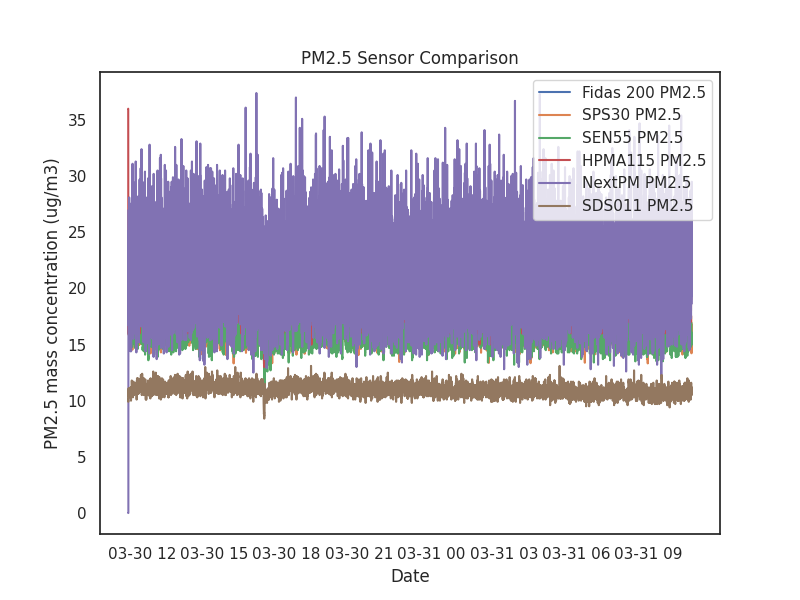

In [141]:
# create a figure and axis object
fig, ax = plt.subplots(figsize=(8,6))

# plot each column using a for loop
for col in deployed_sensors:
    ax.plot(df_pm['DateTime'], df_pm[col], label=col)

# add a legend to the plot
ax.legend()

# set plot title and axis labels
plt.title('PM2.5 Sensor Comparison')
plt.xlabel('Date')
plt.ylabel('PM2.5 mass concentration (ug/m3)')

# show the plot
plt.show()

Plot every pair of sensors against each other

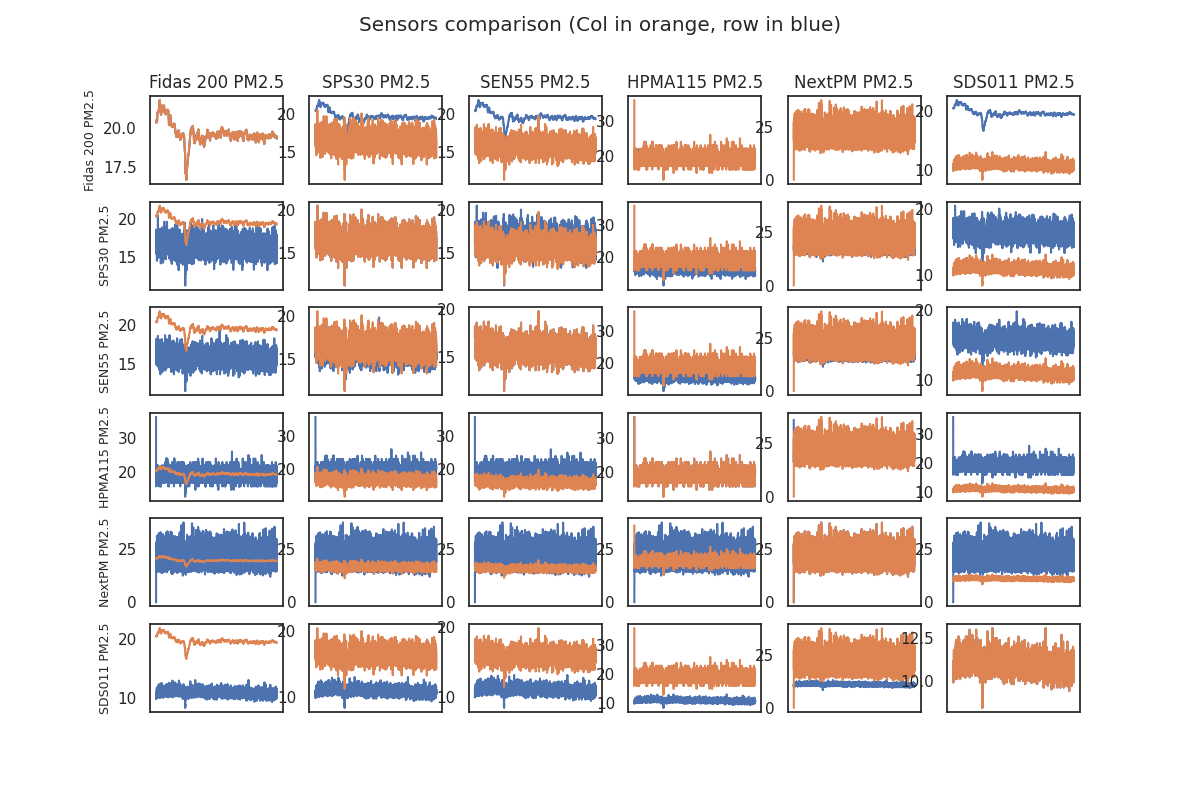

In [142]:

# create a figure object with subplots
fig, axs = plt.subplots(len(deployed_sensors), len(deployed_sensors), figsize=(12, 8), sharex=True)

# loop through all pairs of columns to plot
for i in range(len(deployed_sensors)):
    for j in range(len(deployed_sensors)):
        # plot the columns on the subplot
        if(i==0):
            axs[i, j].set_title(deployed_sensors[j])
        if(j==0):
            axs[i, j].set_ylabel(deployed_sensors[i], fontsize=9)
        axs[i, j].plot(df_pm['DateTime'], df_pm[deployed_sensors[i]], label=deployed_sensors[i])
        axs[i, j].plot(df_pm['DateTime'], df_pm[deployed_sensors[j]], label=deployed_sensors[j])
        axs[i, j].xaxis.set_ticklabels([])
        

# set the plot title
fig.suptitle('Sensors comparison (Col in orange, row in blue)')

# adjust the layout of the subplots
#plt.tight_layout()

# show the plot
plt.show()

Plot correlation matrix

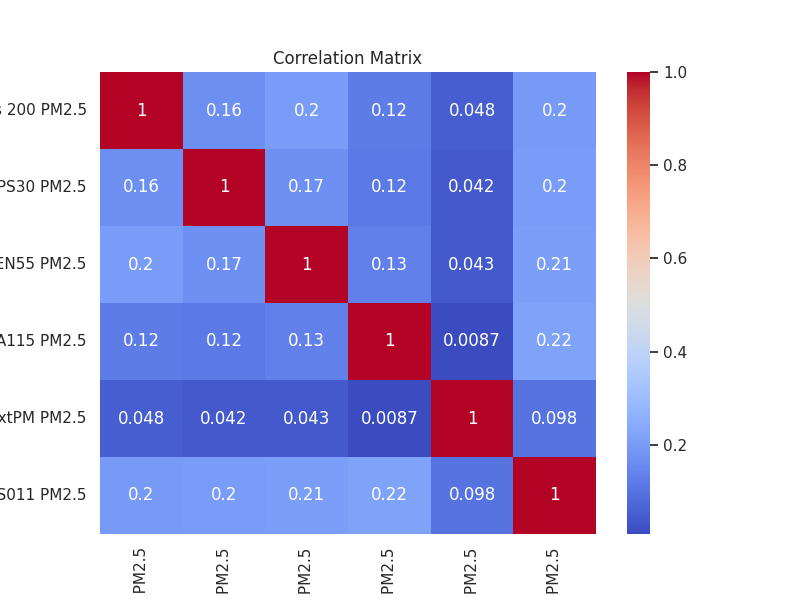

In [143]:
# create a correlation matrix for the selected columns
corr = df_pm[deployed_sensors].corr()

# plot the correlation matrix
sns.set(style='white')
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Calculate r squared between all sensors


In [144]:
# create an empty list to store the R-squared values
r_squared_list = []

# loop through all possible combinations of columns and calculate R-squared
for pair in combinations(deployed_sensors, 2):
    x_col = df_pm[pair[0]]
    y_col = df_pm[pair[1]]
    r_squared = r2_score(x_col, y_col)
    r_squared_list.append((pair[0], pair[1], r_squared))

# sort the list of R-squared values in descending order
r_squared_list.sort(key=lambda x: x[2], reverse=True)

# print the R-squared values
for r in r_squared_list:
    print(f"R-squared between '{r[0]}' and '{r[1]}': {r[2]}")

R-squared between 'SPS30 PM2.5' and 'SEN55 PM2.5': -1.061690321062565
R-squared between 'Fidas 200 PM2.5' and 'HPMA115 PM2.5': -4.369334474695304
R-squared between 'HPMA115 PM2.5' and 'NextPM PM2.5': -7.51875977600063
R-squared between 'NextPM PM2.5' and 'SDS011 PM2.5': -9.18689702682832
R-squared between 'SPS30 PM2.5' and 'HPMA115 PM2.5': -11.646154188080075
R-squared between 'SEN55 PM2.5' and 'HPMA115 PM2.5': -22.03273463029386
R-squared between 'Fidas 200 PM2.5' and 'SPS30 PM2.5': -22.712733448719277
R-squared between 'HPMA115 PM2.5' and 'SDS011 PM2.5': -31.500146953629987
R-squared between 'Fidas 200 PM2.5' and 'NextPM PM2.5': -31.770096981943624
R-squared between 'Fidas 200 PM2.5' and 'SEN55 PM2.5': -32.884019006651776
R-squared between 'SEN55 PM2.5' and 'SDS011 PM2.5': -34.58158356061105
R-squared between 'SPS30 PM2.5' and 'SDS011 PM2.5': -35.11898483119906
R-squared between 'SPS30 PM2.5' and 'NextPM PM2.5': -42.878334813264594
R-squared between 'SEN55 PM2.5' and 'NextPM PM2.5': 

Perform data smoothing

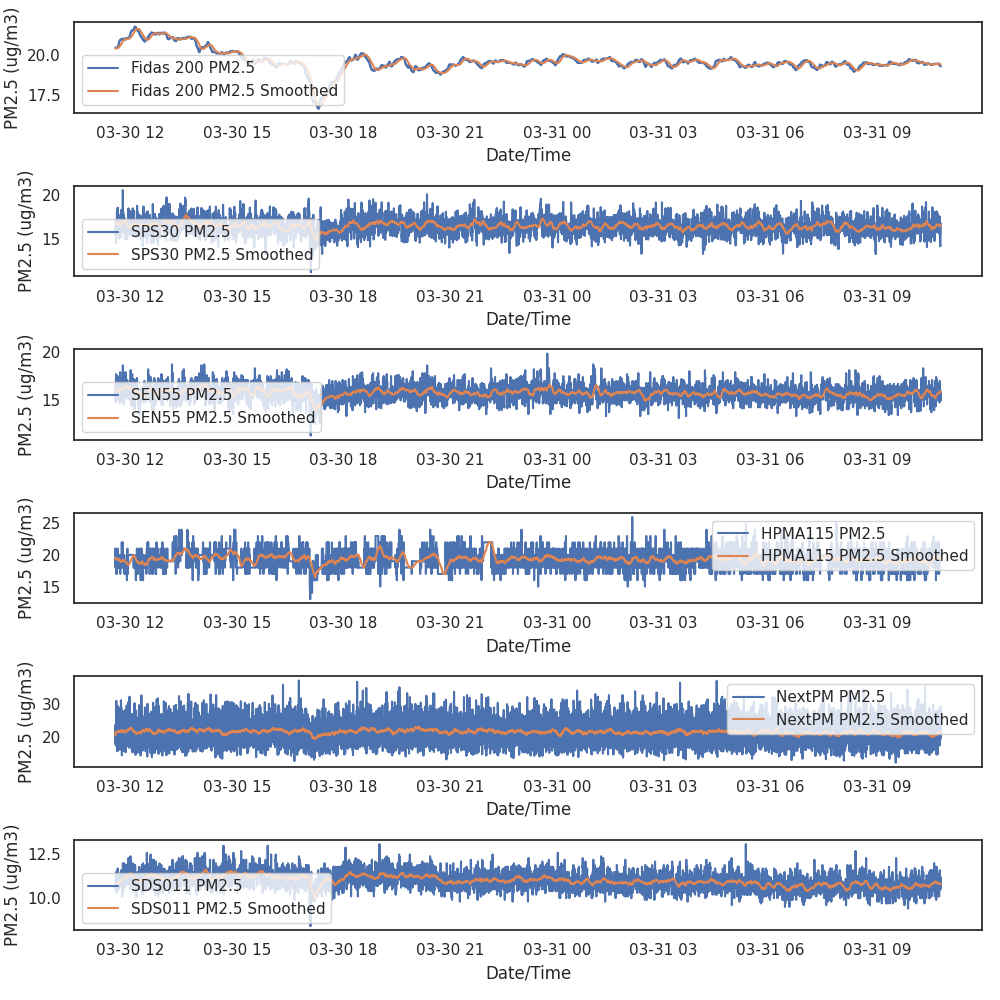

In [145]:
numtoaverage = 100

# loop through each column and perform a 30 point rolling average
for col in deployed_sensors:
    df_pm[f"{col} Smoothed"] = df_pm[col].rolling(window=numtoaverage).mean()

# drop the first 30 rows to avoid NaN values
df_pm = df_pm.iloc[numtoaverage:]

# plot the original and smoothed values for each column
fig, axes = plt.subplots(nrows=len(deployed_sensors), ncols=1, figsize=(10,10))
for i, col in enumerate(deployed_sensors):
    ax = axes[i]
    ax.plot(df_pm['DateTime'], df_pm[col], label=col)
    ax.plot(df_pm['DateTime'], df_pm[f"{col} Smoothed"], label=f"{col} Smoothed")
    ax.set_xlabel('Date/Time')
    ax.set_ylabel('PM2.5 (ug/m3)')
    ax.legend()
plt.tight_layout()
plt.show()






Evaluate correlation for each smoothed element

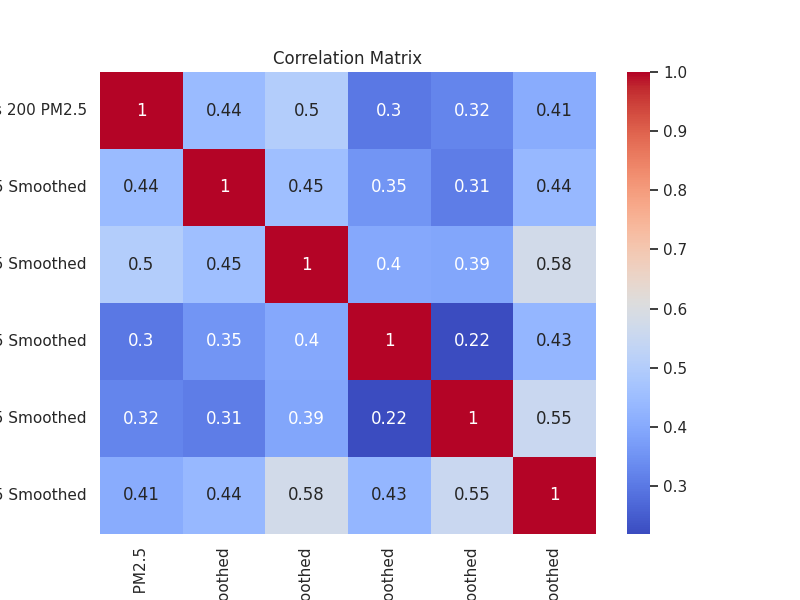

In [146]:
smoothed_deployed_sensors = ['Fidas 200 PM2.5'] + [elem + " Smoothed" for elem in deployed_sensors if elem != 'Fidas 200 PM2.5']


# create a correlation matrix for the selected columns
corr2 = df_pm[smoothed_deployed_sensors].corr()

# plot the correlation matrix
sns.set(style='white')
plt.figure(figsize=(8, 6))
sns.heatmap(corr2, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Evaluate R Squared for smoothed data

In [147]:
# create an empty list to store the R-squared values
smoothed_r_squared_list = []

# loop through all possible combinations of columns and calculate R-squared
for pair in combinations(smoothed_deployed_sensors, 2):
    x_col = df_pm[pair[0]]
    y_col = df_pm[pair[1]]
    r_squared = r2_score(x_col, y_col)
    smoothed_r_squared_list.append((pair[0], pair[1], r_squared))

# sort the list of R-squared values in descending order
smoothed_r_squared_list.sort(key=lambda x: x[2], reverse=True)

# print the R-squared values
for r in smoothed_r_squared_list:
    print(f"R-squared between '{r[0]}' and '{r[1]}': {r[2]}")

R-squared between 'Fidas 200 PM2.5' and 'HPMA115 PM2.5 Smoothed': -0.45617118577878535
R-squared between 'SPS30 PM2.5 Smoothed' and 'SEN55 PM2.5 Smoothed': -4.694666210073732
R-squared between 'Fidas 200 PM2.5' and 'NextPM PM2.5 Smoothed': -7.2488569185797385
R-squared between 'HPMA115 PM2.5 Smoothed' and 'NextPM PM2.5 Smoothed': -13.908148281595814
R-squared between 'Fidas 200 PM2.5' and 'SPS30 PM2.5 Smoothed': -21.145955261215335
R-squared between 'Fidas 200 PM2.5' and 'SEN55 PM2.5 Smoothed': -31.745353771002492
R-squared between 'SPS30 PM2.5 Smoothed' and 'HPMA115 PM2.5 Smoothed': -75.4060301169909
R-squared between 'SEN55 PM2.5 Smoothed' and 'HPMA115 PM2.5 Smoothed': -118.30511896775309
R-squared between 'Fidas 200 PM2.5' and 'SDS011 PM2.5 Smoothed': -158.20258989484864
R-squared between 'HPMA115 PM2.5 Smoothed' and 'SDS011 PM2.5 Smoothed': -198.37825524901052
R-squared between 'SEN55 PM2.5 Smoothed' and 'SDS011 PM2.5 Smoothed': -208.46815243219734
R-squared between 'SPS30 PM2.5 Sm

Plot smoothed data against each other

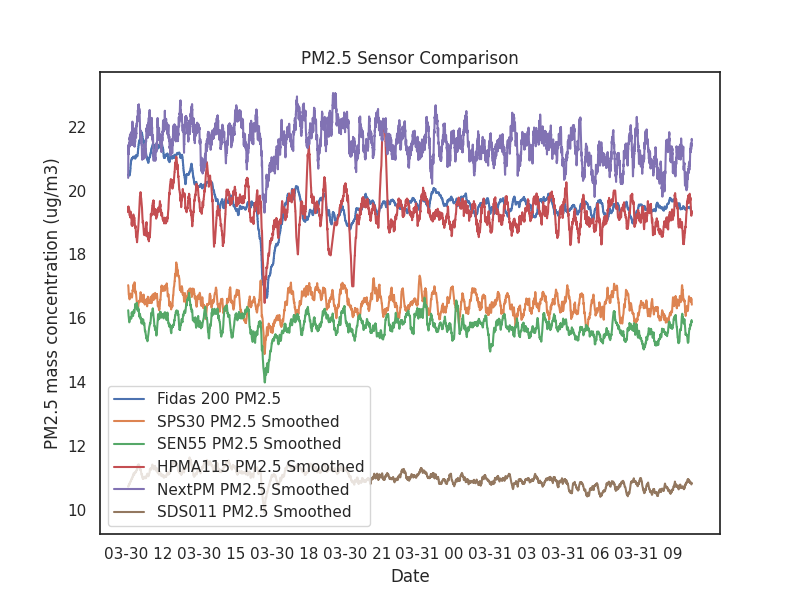

In [148]:
# create a figure and axis object
fig, ax = plt.subplots(figsize=(8,6))

# plot each column using a for loop
for col in smoothed_deployed_sensors:
    ax.plot(df_pm['DateTime'], df_pm[col], label=col)

# add a legend to the plot
ax.legend()

# set plot title and axis labels
plt.title('PM2.5 Sensor Comparison')
plt.xlabel('Date')
plt.ylabel('PM2.5 mass concentration (ug/m3)')

# show the plot
plt.show()

Run mass plotting again with smoothed data

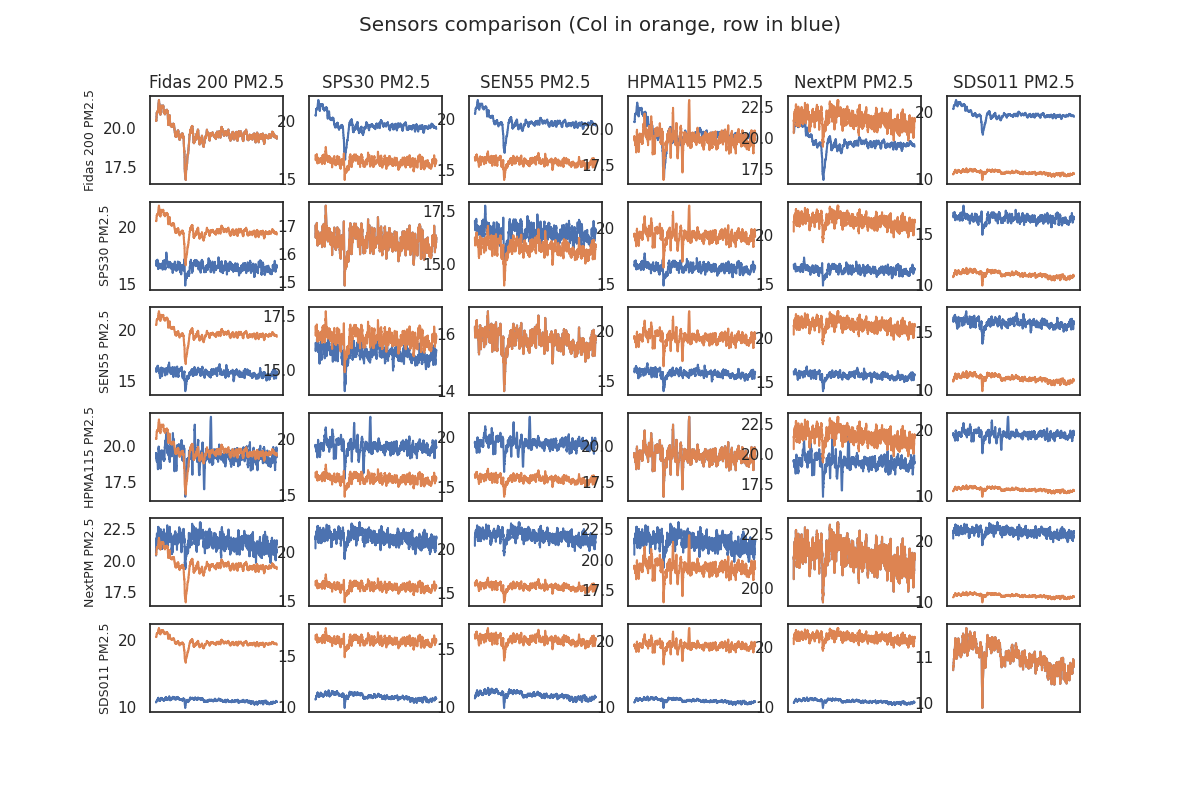

In [149]:
# create a figure object with subplots
fig, axs = plt.subplots(len(smoothed_deployed_sensors), len(smoothed_deployed_sensors), figsize=(12, 8), sharex=True)

# loop through all pairs of columns to plot
for i in range(len(smoothed_deployed_sensors)):
    for j in range(len(smoothed_deployed_sensors)):
        # plot the columns on the subplot
        if(i==0):
            axs[i, j].set_title(deployed_sensors[j])
        if(j==0):
            axs[i, j].set_ylabel(deployed_sensors[i], fontsize=9)
        axs[i, j].plot(df_pm['DateTime'], df_pm[smoothed_deployed_sensors[i]], label=deployed_sensors[i])
        axs[i, j].plot(df_pm['DateTime'], df_pm[smoothed_deployed_sensors[j]], label=deployed_sensors[j])
        axs[i, j].xaxis.set_ticklabels([])
        

# set the plot title
fig.suptitle('Sensors comparison (Col in orange, row in blue)')

# adjust the layout of the subplots
#plt.tight_layout()

# show the plot
plt.show()


Experiment with new denoising algos

RMSE :  0.8355172131217997
R-squared : -0.4786267230744168


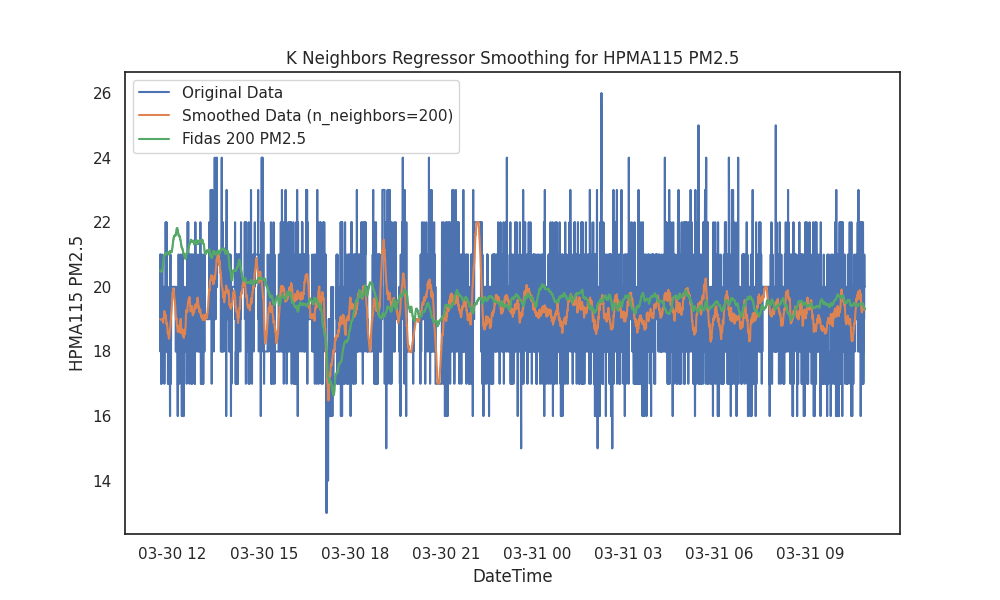

In [150]:
sensor_to_eval = 'HPMA115 PM2.5'

# extract the input features and target variable
X = df_pm[['DateTime']]   # input features
y = df_pm[sensor_to_eval]  # target variable

# create an instance of the KNN regressor
knn = KNeighborsRegressor(n_neighbors=100)

# fit the model to the data
knn.fit(X, y)

# make predictions on the input features
y_pred = knn.predict(X)

rmse = mean_squared_error(df_pm['Fidas 200 PM2.5'], y_pred , squared=False)
r2 = r2_score(df_pm['Fidas 200 PM2.5'], y_pred )
print('RMSE : ', rmse)
print('R-squared :', r2)

plt.figure(figsize=(10, 6))
plt.plot(df_pm['DateTime'], y, label='Original Data')
plt.plot(df_pm['DateTime'], y_pred, label='Smoothed Data (n_neighbors=200)')
plt.plot(df_pm['DateTime'], df_pm['Fidas 200 PM2.5'], label='Fidas 200 PM2.5')
plt.xlabel('DateTime')
plt.ylabel(sensor_to_eval)
plt.title('K Neighbors Regressor Smoothing for {}'.format(sensor_to_eval))
plt.legend()
plt.show()

# Incinerate laptop

Run KNN data smoothing on each sample, find the best neighbours value, plot graph and store in original dataframe

Lowest RMSE: 3.2340, Neighbors: 100
Highest R-squared: -21.1529, Neighbors: 100


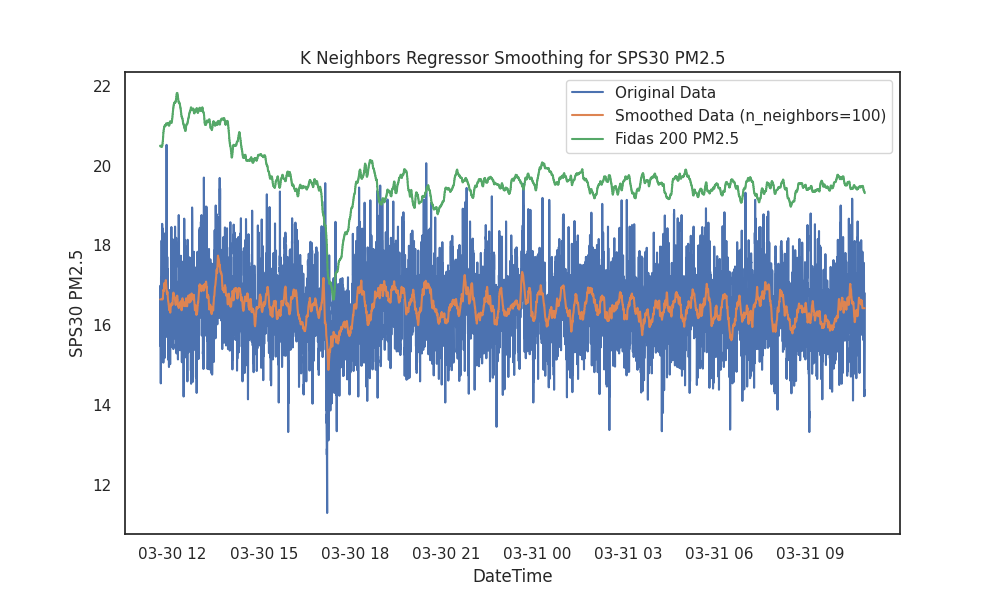

/tmp/ipykernel_637969/747947660.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pm[sensor_to_eval+' KNN'] = smoothed_data[rmse_values.index(min_rmse)]


Lowest RMSE: 3.9326, Neighbors: 100
Highest R-squared: -31.7566, Neighbors: 100


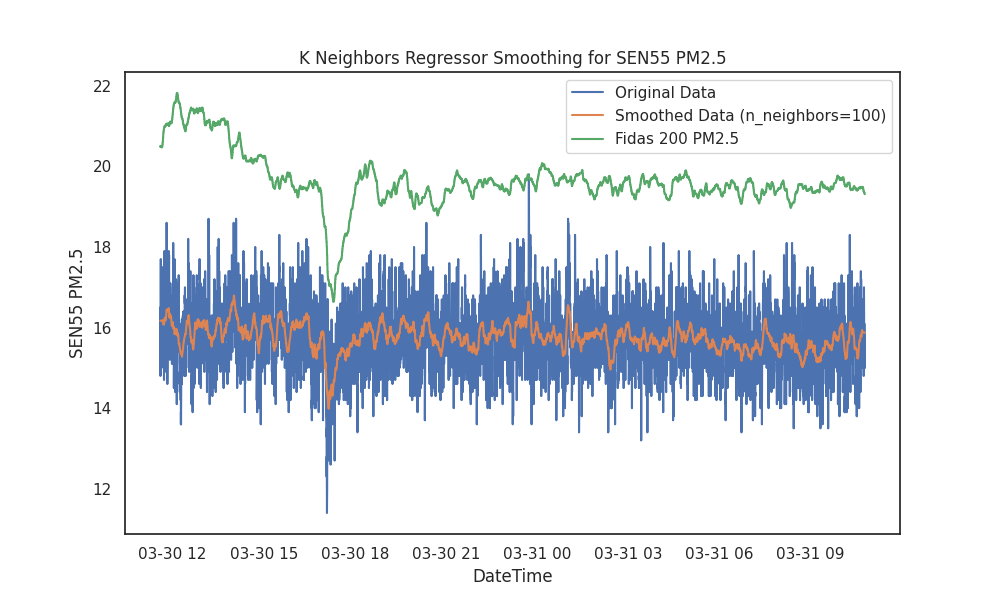

/tmp/ipykernel_637969/747947660.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pm[sensor_to_eval+' KNN'] = smoothed_data[rmse_values.index(min_rmse)]


Lowest RMSE: 0.8355, Neighbors: 100
Highest R-squared: -0.4786, Neighbors: 100


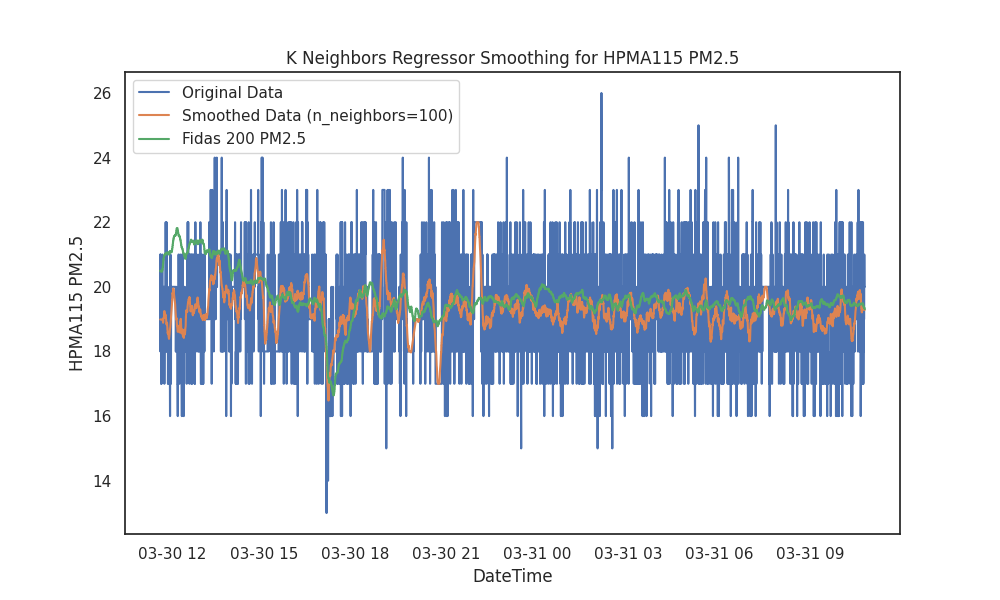

/tmp/ipykernel_637969/747947660.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pm[sensor_to_eval+' KNN'] = smoothed_data[rmse_values.index(min_rmse)]


Lowest RMSE: 1.9726, Neighbors: 100
Highest R-squared: -7.2420, Neighbors: 100


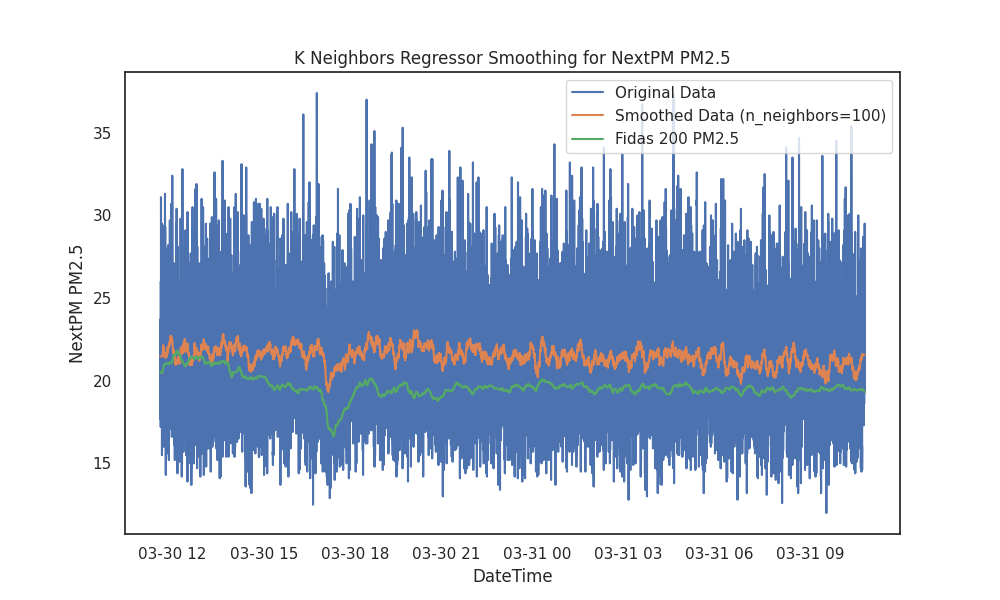

/tmp/ipykernel_637969/747947660.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pm[sensor_to_eval+' KNN'] = smoothed_data[rmse_values.index(min_rmse)]


Lowest RMSE: 8.6696, Neighbors: 100
Highest R-squared: -158.1999, Neighbors: 100


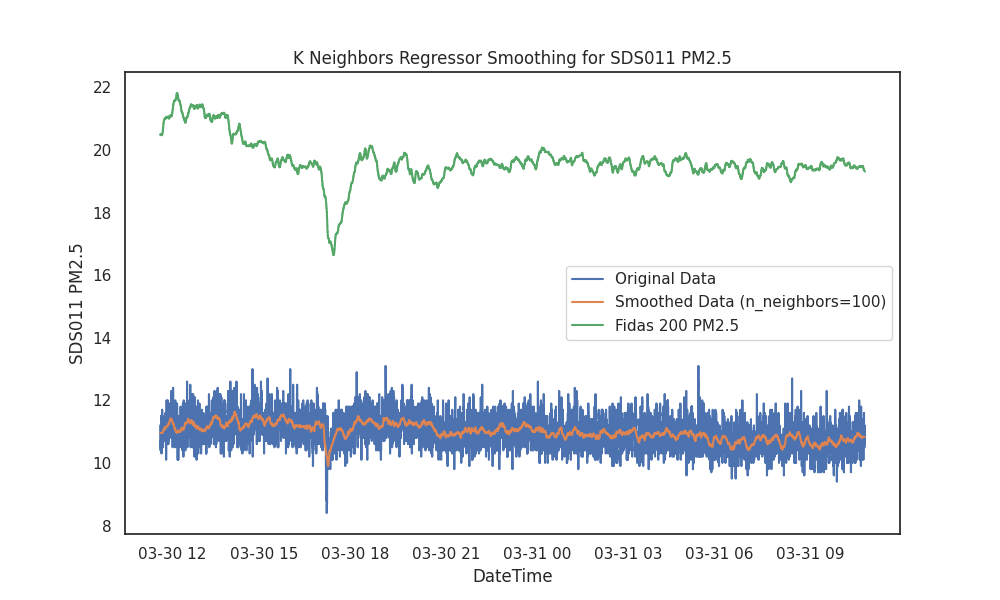

/tmp/ipykernel_637969/747947660.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pm[sensor_to_eval+' KNN'] = smoothed_data[rmse_values.index(min_rmse)]


In [151]:

sensor_to_eval = 'NextPM PM2.5'

for col in no_fidas:
    sensor_to_eval = col
    # Extract the datetime column and sensor column
    datetime_col = df_pm['DateTime']
    sensor_col = df_pm[sensor_to_eval]

    # Define the range of n_neighbors values to iterate over
    n_neighbors_range = [100]

    # Initialize an empty array to store the smoothed data for each n_neighbors value
    smoothed_data = []
    r2_values = []
    rmse_values = []


    # Loop through the n_neighbors values and apply KNeighborsRegressor for each value
    for n_neighbors in n_neighbors_range:
        # Initialize the KNeighborsRegressor with the specified n_neighbors value
        knn = KNeighborsRegressor(n_neighbors=n_neighbors)
        # Fit the model with the original sensor data
        knn.fit(datetime_col.values.reshape(-1, 1), sensor_col.values)
        # Predict the smoothed sensor data using the model
        smoothed_sensor_data = knn.predict(datetime_col.values.reshape(-1, 1))
        # Append the smoothed data to the list of smoothed data
        smoothed_data.append(smoothed_sensor_data)

        rmse = mean_squared_error(df_pm['Fidas 200 PM2.5'], smoothed_sensor_data , squared=False)
        r2 = r2_score(df_pm['Fidas 200 PM2.5'], smoothed_sensor_data )
        rmse_values.append(rmse)
        r2_values.append(r2)

    # Find the lowest RMSE and highest R-squared values and their corresponding neighbors value
    min_rmse = min(rmse_values)
    max_r2 = max(r2_values)
    best_neighbors_rmse = n_neighbors_range[rmse_values.index(min_rmse)]
    best_neighbors_r2 = n_neighbors_range[r2_values.index(max_r2)]

    # Print the results
    print('Lowest RMSE: {:.4f}, Neighbors: {}'.format(min_rmse, best_neighbors_rmse))
    print('Highest R-squared: {:.4f}, Neighbors: {}'.format(max_r2, best_neighbors_r2))

    # Plot the original and smoothed data on the same axis
    plt.figure(figsize=(10, 6))
    plt.plot(datetime_col, sensor_col, label='Original Data')

    plt.plot(datetime_col, smoothed_data[rmse_values.index(min_rmse)], label='Smoothed Data (n_neighbors={})'.format(n_neighbors_range[rmse_values.index(min_rmse)]))
    plt.plot(df_pm['DateTime'], df_pm['Fidas 200 PM2.5'], label='Fidas 200 PM2.5')
    plt.xlabel('DateTime')
    plt.ylabel(sensor_to_eval)
    plt.title('K Neighbors Regressor Smoothing for {}'.format(sensor_to_eval))
    plt.legend()
    plt.show()
    df_pm[sensor_to_eval+' KNN'] = smoothed_data[rmse_values.index(min_rmse)]

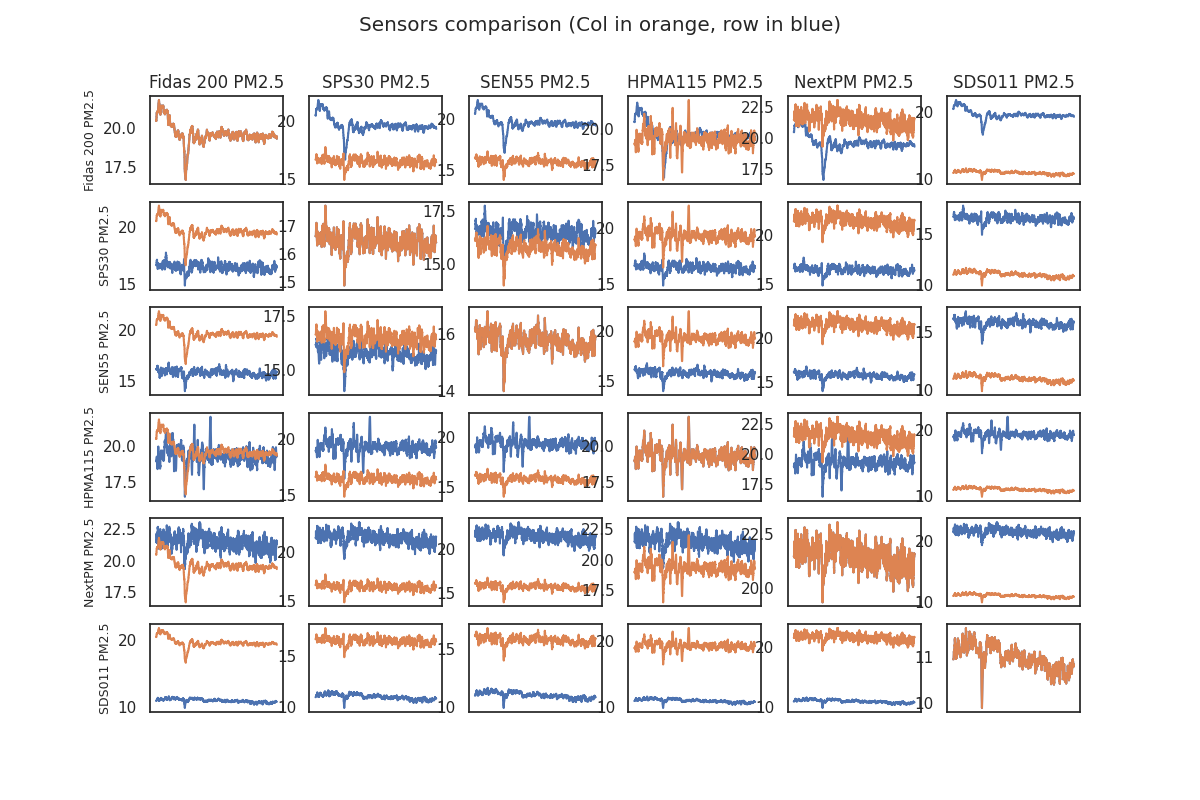

In [152]:
knn_deployed_sensors = ['Fidas 200 PM2.5'] + [elem + " KNN" for elem in deployed_sensors if elem != 'Fidas 200 PM2.5']
fig, axs = plt.subplots(len(knn_deployed_sensors), len(knn_deployed_sensors), figsize=(12, 8), sharex=True)

# loop through all pairs of columns to plot
for i in range(len(knn_deployed_sensors)):
    for j in range(len(knn_deployed_sensors)):
        # plot the columns on the subplot
        if(i==0):
            axs[i, j].set_title(deployed_sensors[j])
        if(j==0):
            axs[i, j].set_ylabel(deployed_sensors[i], fontsize=9)
        axs[i, j].plot(df_pm['DateTime'], df_pm[knn_deployed_sensors[i]], label=deployed_sensors[i])
        axs[i, j].plot(df_pm['DateTime'], df_pm[knn_deployed_sensors[j]], label=deployed_sensors[j])
        axs[i, j].xaxis.set_ticklabels([])
        

# set the plot title
fig.suptitle('Sensors comparison (Col in orange, row in blue)')

# adjust the layout of the subplots
#plt.tight_layout()

# show the plot
plt.show()

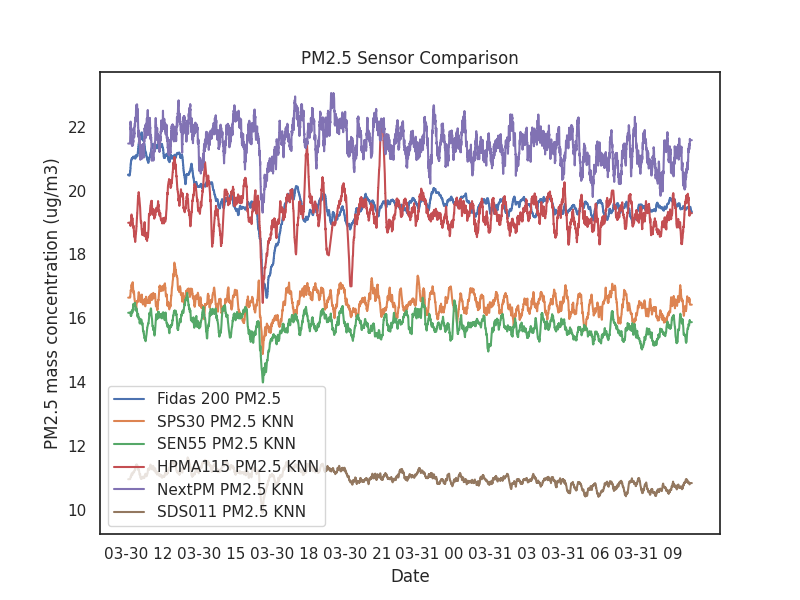

In [153]:
# create a figure and axis object
fig, ax = plt.subplots(figsize=(8,6))

# plot each column using a for loop
for col in knn_deployed_sensors:
    ax.plot(df_pm['DateTime'], df_pm[col], label=col)

# add a legend to the plot
ax.legend()

# set plot title and axis labels
plt.title('PM2.5 Sensor Comparison')
plt.xlabel('Date')
plt.ylabel('PM2.5 mass concentration (ug/m3)')

# show the plot
plt.show()

In [154]:
df_pm['Fidas 200 PM2.5'].describe()

count    14900.000000
mean        19.644452
std          0.687133
min         16.640000
25%         19.380000
50%         19.560000
75%         19.740000
max         21.820000
Name: Fidas 200 PM2.5, dtype: float64

# Incinerate laptop 2: electric boogaloo

Apply Savitsky-Golay filter to the data. Iterate lots of different values to try and find best parameters

RMSE :  3.2494438477545287
R-squared : -21.364841301613097
R-order : 3
Best Window Size: 100
Best Polynomial Order: 3
Best RMSE: 3.2494
Best R-squared: -21.3648


/tmp/ipykernel_637969/213941396.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pm[sensor_to_eval+' SavGol'] = smoothed_data


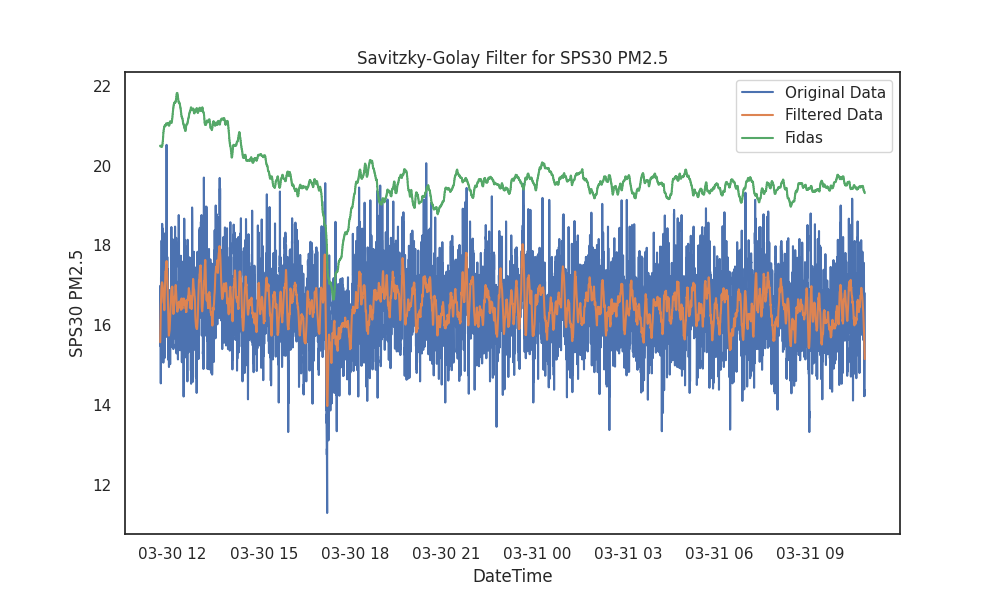

RMSE :  3.9417282081281715
R-squared : -31.909485933174047
R-order : 3
Best Window Size: 100
Best Polynomial Order: 3
Best RMSE: 3.9417
Best R-squared: -31.9095


/tmp/ipykernel_637969/213941396.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pm[sensor_to_eval+' SavGol'] = smoothed_data


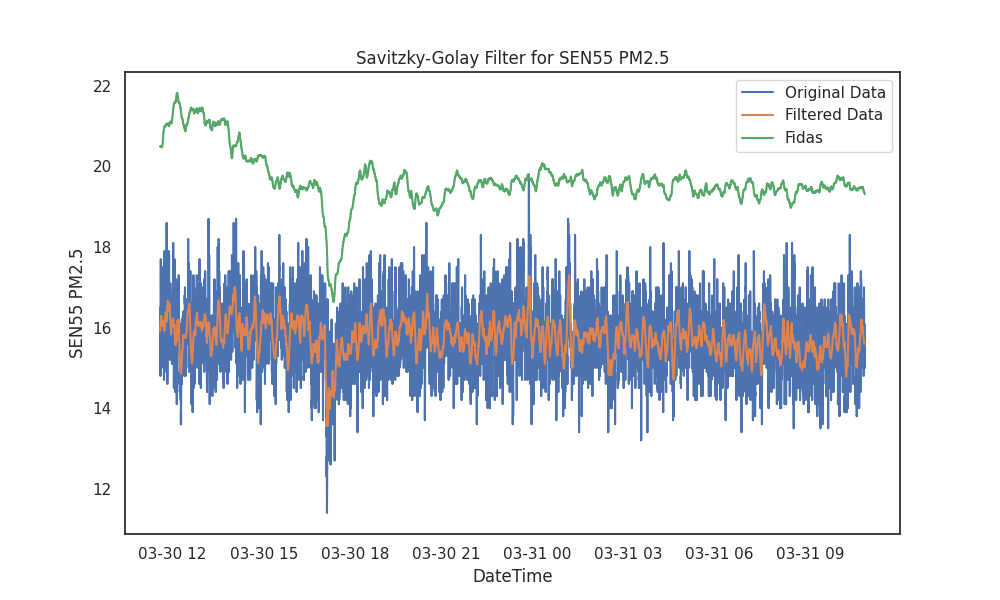

RMSE :  0.9453652207101786
R-squared : -0.8929842020648808
R-order : 3
Best Window Size: 100
Best Polynomial Order: 3
Best RMSE: 0.9454
Best R-squared: -0.8930


/tmp/ipykernel_637969/213941396.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pm[sensor_to_eval+' SavGol'] = smoothed_data


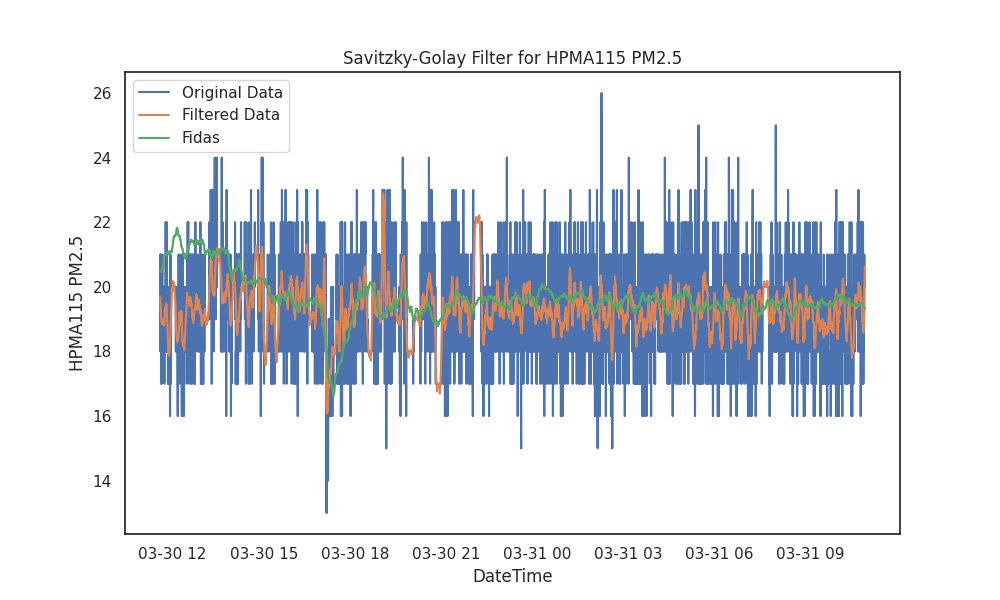

RMSE :  2.0446353415107756
R-squared : -7.854814639310499
R-order : 3
Best Window Size: 100
Best Polynomial Order: 3
Best RMSE: 2.0446
Best R-squared: -7.8548


/tmp/ipykernel_637969/213941396.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pm[sensor_to_eval+' SavGol'] = smoothed_data


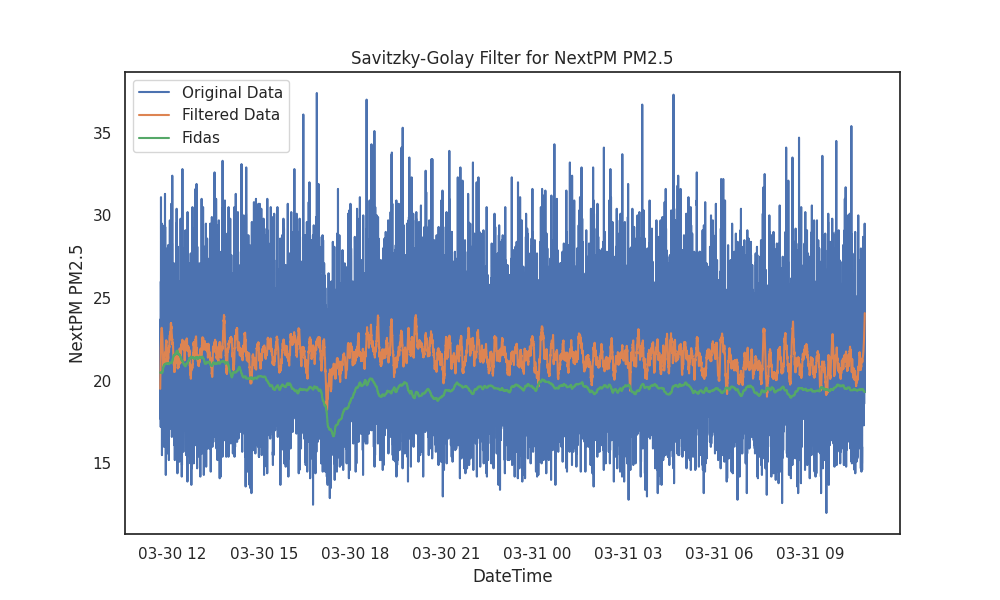

RMSE :  8.670553624844771
R-squared : -158.23605328513818
R-order : 3
Best Window Size: 100
Best Polynomial Order: 3
Best RMSE: 8.6706
Best R-squared: -158.2361


/tmp/ipykernel_637969/213941396.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pm[sensor_to_eval+' SavGol'] = smoothed_data


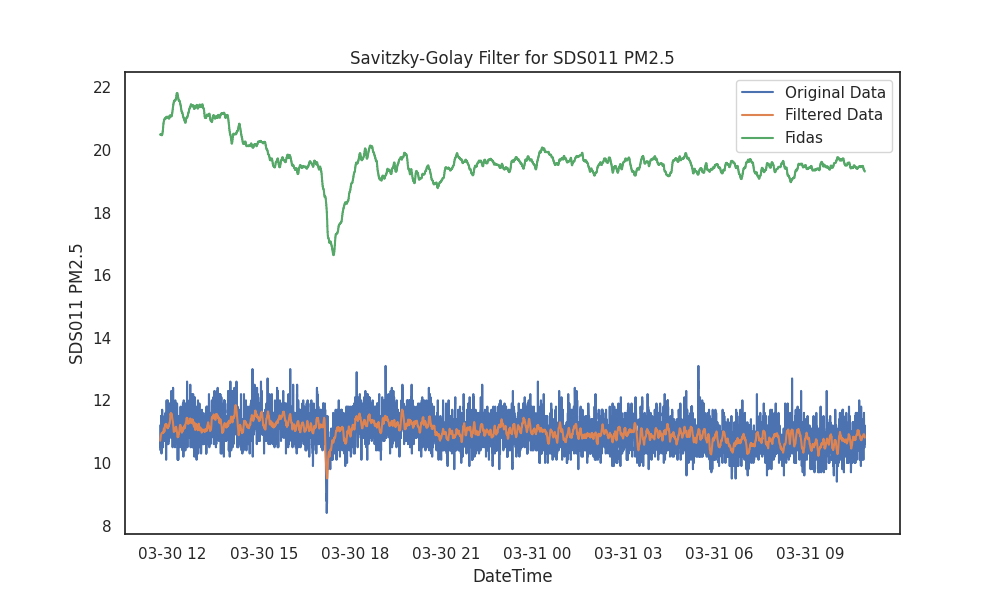

In [185]:
ideal_data_col = 'Fidas 200 PM2.5'  # Column name for ideal data
sensor_to_eval = 'SPS30 PM2.5'  # Replace with the actual column name for noisy data

# Define the range of window sizes and polynomial order for Savitzky-Golay filter
#window_sizes = np.arange(10, 501, 10)  # Range of window sizes from 10 to 500 with step of 10
window_sizes = [100]
poly_orders = [3]  # Range of polynomial orders from 1 to 5

for col in no_fidas:
    sensor_to_eval = col

    # Initialize variables to store the best parameters and error metrics
    best_window_size = None
    best_poly_order = None
    best_rmse = float('inf')
    best_r2 = float('-inf')

    # Loop through all possible combinations of window sizes and polynomial orders
    for window_size in window_sizes:
        for poly_order in poly_orders:
            # Apply Savitzky-Golay filter on the noisy data
            smoothed_data = savgol_filter(df_pm[sensor_to_eval], window_size, poly_order)
            
            # Calculate RMSE and R-squared between smoothed data and ideal data
            rmse = np.sqrt(mean_squared_error(df_pm[ideal_data_col], smoothed_data))
            r2 = r2_score(df_pm[ideal_data_col], smoothed_data)
            
            # Update the best parameters and error metrics if necessary
            if rmse < best_rmse:
                best_rmse = rmse
                best_window_size = window_size
                best_poly_order = poly_order
            
            if r2 > best_r2:
                best_r2 = r2
                best_window_size = window_size
                best_poly_order = poly_order
            
            print('RMSE : ', rmse)
            print('R-squared :', r2)
            print('R-order :', poly_order)


    # Print the best parameters and error metrics
    print('Best Window Size: {}'.format(best_window_size))
    print('Best Polynomial Order: {}'.format(best_poly_order))
    print('Best RMSE: {:.4f}'.format(best_rmse))
    print('Best R-squared: {:.4f}'.format(best_r2))

    # Apply Savitzky-Golay filter on the noisy data
    smoothed_data = savgol_filter(df_pm[sensor_to_eval], best_window_size, best_poly_order)
    df_pm[sensor_to_eval+' SavGol'] = smoothed_data
    # plot the original and filtered data on the same axis
    plt.figure(figsize=(10, 6))
    plt.plot(df_pm['DateTime'], df_pm[sensor_to_eval], label='Original Data')
    plt.plot(df_pm['DateTime'], smoothed_data, label='Filtered Data')
    plt.plot(df_pm['DateTime'], df_pm['Fidas 200 PM2.5'], label='Fidas')
    plt.xlabel('DateTime')
    plt.ylabel(sensor_to_eval)
    plt.legend()
    plt.title('Savitzky-Golay Filter for {}'.format(sensor_to_eval))
    plt.show()

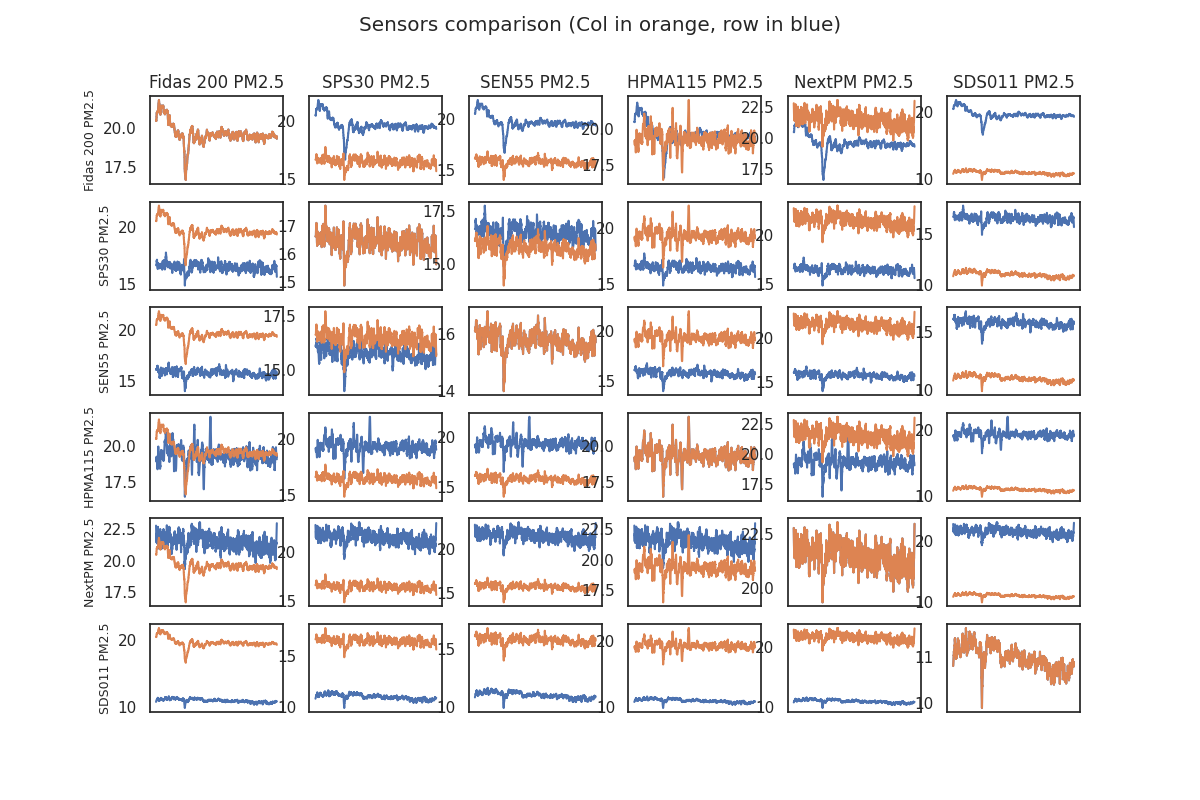

In [156]:
savgol_deployed_sensors = ['Fidas 200 PM2.5'] + [elem + " SavGol" for elem in deployed_sensors if elem != 'Fidas 200 PM2.5']
fig, axs = plt.subplots(len(savgol_deployed_sensors), len(savgol_deployed_sensors), figsize=(12, 8), sharex=True)

# loop through all pairs of columns to plot
for i in range(len(savgol_deployed_sensors)):
    for j in range(len(savgol_deployed_sensors)):
        # plot the columns on the subplot
        if(i==0):
            axs[i, j].set_title(deployed_sensors[j])
        if(j==0):
            axs[i, j].set_ylabel(deployed_sensors[i], fontsize=9)
        axs[i, j].plot(df_pm['DateTime'], df_pm[savgol_deployed_sensors[i]], label=deployed_sensors[i])
        axs[i, j].plot(df_pm['DateTime'], df_pm[savgol_deployed_sensors[j]], label=deployed_sensors[j])
        axs[i, j].xaxis.set_ticklabels([])
        

# set the plot title
fig.suptitle('Sensors comparison (Col in orange, row in blue)')

# adjust the layout of the subplots
#plt.tight_layout()

# show the plot
plt.show()

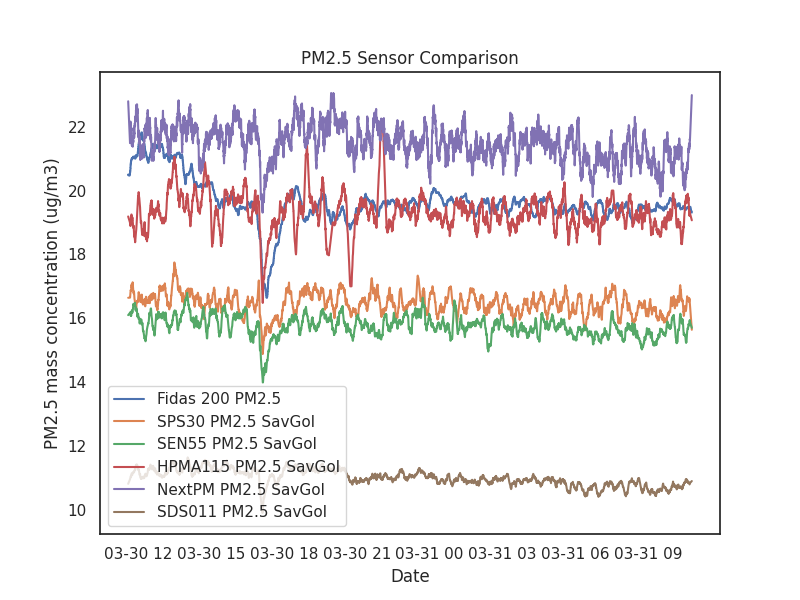

In [157]:
# create a figure and axis object
fig, ax = plt.subplots(figsize=(8,6))

# plot each column using a for loop
for col in savgol_deployed_sensors:
    ax.plot(df_pm['DateTime'], df_pm[col], label=col)

# add a legend to the plot
ax.legend()

# set plot title and axis labels
plt.title('PM2.5 Sensor Comparison')
plt.xlabel('Date')
plt.ylabel('PM2.5 mass concentration (ug/m3)')

# show the plot
plt.show()

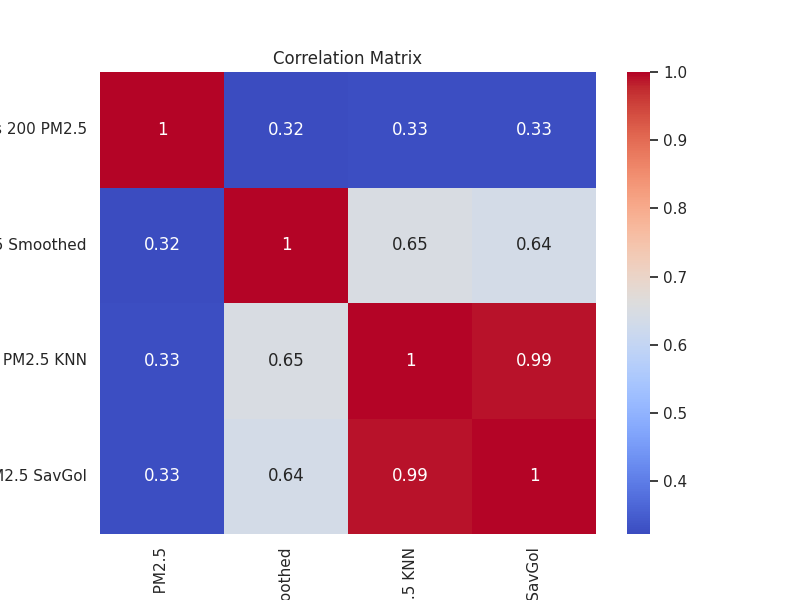

In [158]:
col = 'NextPM PM2.5'
a = col + ' Smoothed'
b = col + ' KNN'
c = col + ' SavGol'
d = 'Fidas 200 PM2.5'
corr2 = df_pm[[d, a, b, c]].corr()


# plot the correlation matrix
sns.set(style='white')
plt.figure(figsize=(8, 6))
sns.heatmap(corr2, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [177]:
print(np.sqrt(mean_squared_error(df_pm['Fidas 200 PM2.5'], df_pm[a])))
print(np.sqrt(mean_squared_error(df_pm['Fidas 200 PM2.5'], df_pm[b])))
print(np.sqrt(mean_squared_error(df_pm['Fidas 200 PM2.5'], df_pm[c])))

1.9734358406038608
1.9726195359872083
2.0446353415107756


/tmp/ipykernel_637969/2061904046.py:1: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
/tmp/ipykernel_637969/2061904046.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)


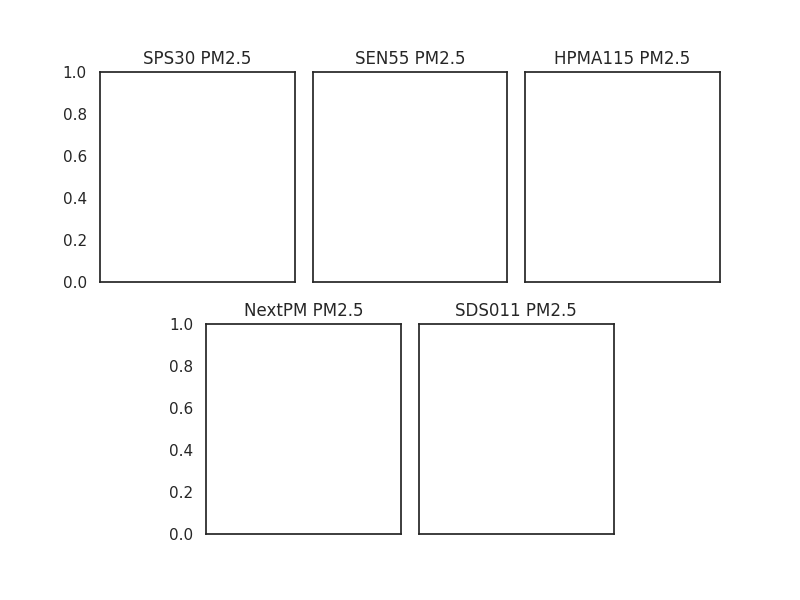

In [161]:
ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)


ax1.plot(df_pm['DateTime'], df_pm[deployed_sensors[1]], label=deployed_sensors[1])
ax1.plot(df_pm['DateTime'], df_pm['Fidas 200 PM2.5'])
ax1.xaxis.set_ticklabels([])
ax1.set_title(deployed_sensors[1])
ax1.set_ylim(0, 1)
ax1.yaxis.set_label('PM2.5 mass concentration (ug/m3)')
ax2.plot(df_pm['DateTime'], df_pm[deployed_sensors[2]], label=deployed_sensors[2])
ax2.plot(df_pm['DateTime'], df_pm['Fidas 200 PM2.5'])
ax2.xaxis.set_ticklabels([])
ax2.yaxis.set_ticklabels([])
ax2.set_title(deployed_sensors[2])
ax2.set_ylim(0, 1)
ax3.plot(df_pm['DateTime'], df_pm[deployed_sensors[3]], label=deployed_sensors[3])
ax3.plot(df_pm['DateTime'], df_pm['Fidas 200 PM2.5'])
ax3.xaxis.set_ticklabels([])
ax3.yaxis.set_ticklabels([])
ax3.set_title(deployed_sensors[3])
ax3.set_ylim(0, 1)
ax4.plot(df_pm['DateTime'], df_pm[deployed_sensors[4]], label=deployed_sensors[4])
ax4.plot(df_pm['DateTime'], df_pm['Fidas 200 PM2.5'])
ax4.xaxis.set_ticklabels([])
ax4.set_title(deployed_sensors[4])
ax4.set_ylim(0, 1)
ax5.plot(df_pm['DateTime'], df_pm[deployed_sensors[5]], label=deployed_sensors[5])
ax5.plot(df_pm['DateTime'], df_pm['Fidas 200 PM2.5'])
ax5.xaxis.set_ticklabels([])
ax5.yaxis.set_ticklabels([])
ax5.set_title(deployed_sensors[5])
ax5.set_ylim(0, 1)


# set the plot title

# adjust the layout of the subplots
#plt.tight_layout()

# show the plot
plt.show()

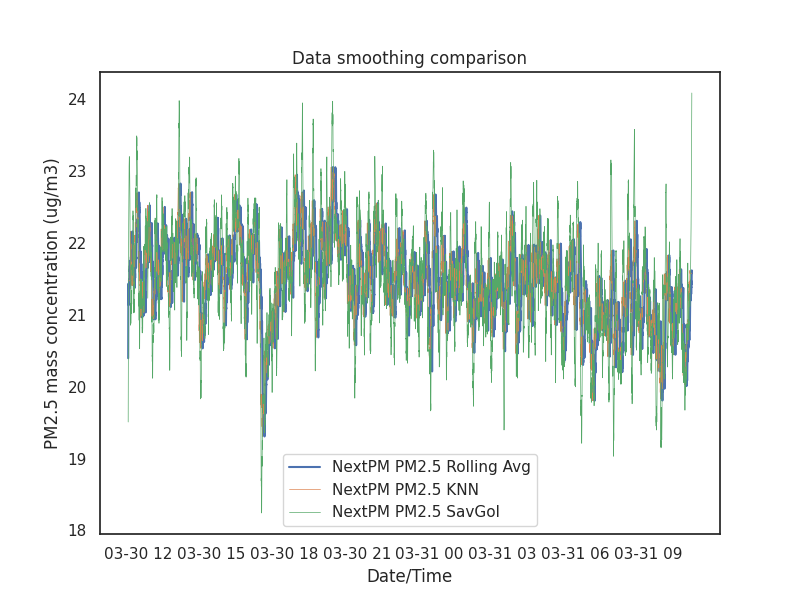

In [191]:
# create a figure and axis object
fig, ax = plt.subplots(figsize=(8,6))


ax.plot(df_pm['DateTime'], df_pm[a], label='NextPM PM2.5 Rolling Avg')
ax.plot(df_pm['DateTime'], df_pm[b], label=b, linewidth=0.5)
ax.plot(df_pm['DateTime'], df_pm[c], label=c, linewidth=0.5)
#ax.plot(df_pm['DateTime'], df_pm[d], label=d)

# add a legend to the plot
ax.legend()

# set plot title and axis labels
plt.title('Data smoothing comparison')
plt.xlabel('Date/Time')
plt.ylabel('PM2.5 mass concentration (ug/m3)')

# show the plot
plt.show()

14900
14900


/tmp/ipykernel_637969/1385012921.py:8: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ax.plot(df_pm['DateTime'][100:200], df_pm[a][100:200], label='NextPM PM2.5 Rolling Avg')
/tmp/ipykernel_637969/1385012921.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ax.plot(df_pm['DateTime'][100:200], df_pm[b][100:200], label=b)
/tmp/ipykernel_637969/1385012921.py:10: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be

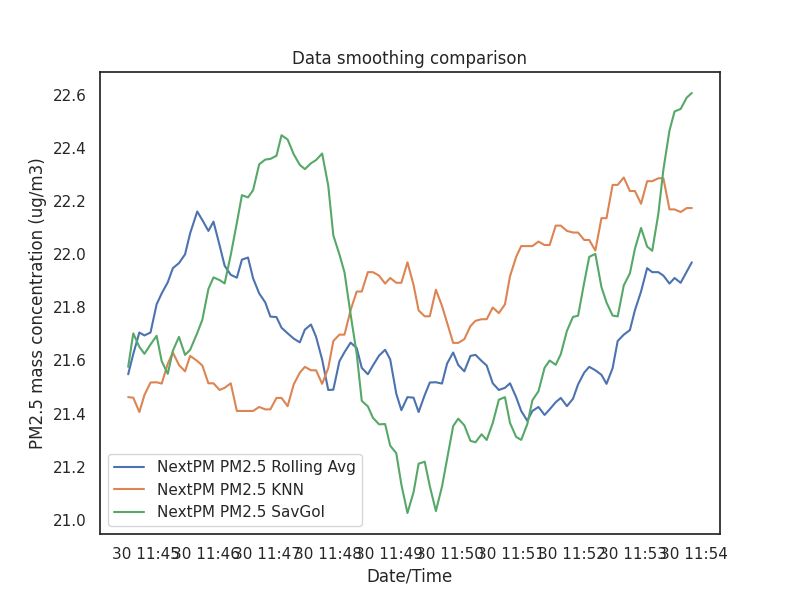

In [186]:
# create a figure and axis object
fig, ax = plt.subplots(figsize=(8,6))

print(len(df_pm[a]))
print(len(df_pm[c]))

#ax.plot(df_pm['DateTime'][100:200], df_pm[col][100:200], label='real')
ax.plot(df_pm['DateTime'][100:200], df_pm[a][100:200], label='NextPM PM2.5 Rolling Avg')
ax.plot(df_pm['DateTime'][100:200], df_pm[b][100:200], label=b)
ax.plot(df_pm['DateTime'][100:200], df_pm[c][100:200], label=c)
#ax.plot(df_pm['DateTime'], df_pm[d], label=d)

# add a legend to the plot
ax.legend()

# set plot title and axis labels
plt.title('Data smoothing comparison')
plt.xlabel('Date/Time')
plt.ylabel('PM2.5 mass concentration (ug/m3)')

# show the plot
plt.show()

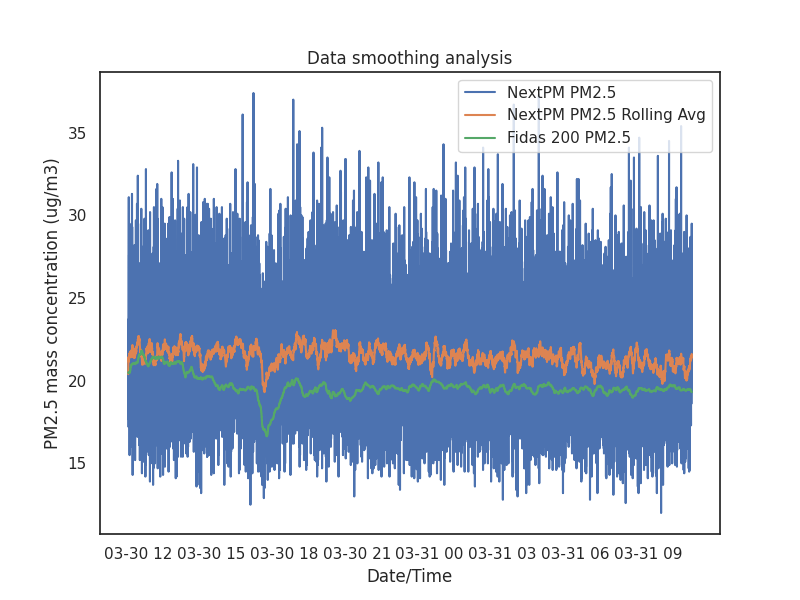

In [ ]:
# create a figure and axis object
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(df_pm['DateTime'], df_pm[col], label=col)
ax.plot(df_pm['DateTime'], df_pm[a], label='NextPM PM2.5 Rolling Avg')

ax.plot(df_pm['DateTime'], df_pm[d], label=d)

# add a legend to the plot
ax.legend()

# set plot title and axis labels
plt.title('Data smoothing analysis')
plt.xlabel('Date/Time')
plt.ylabel('PM2.5 mass concentration (ug/m3)')

# show the plot
plt.show()